In [3]:
using Catlab, Catlab.CategoricalAlgebra, Catlab.Programs, Catlab.WiringDiagrams, Catlab.Graphics 
using AlgebraicPetri 
using AlgebraicDynamics.UWDDynam 

using DifferentialEquations 

using LabelledArrays 
using Plots

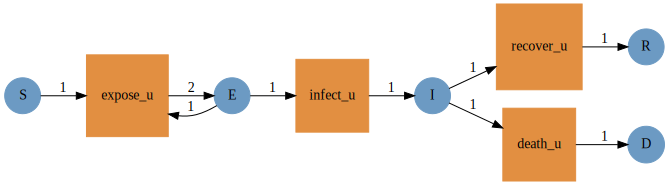

In [4]:
# An SIERD Model (Susceptible, Exposed, Infected, Recovered, Deceased)
SEIRD_opetri_net = Open(LabelledPetriNet(
    
    [:S, :E, :I, :R, :D], 

    :expose_u => ((:S, :E) => (:E, :E)),
    :infect_u => ((:E) => (:I)),
    :recover_u => ((:I) => (:R)),
    :death_u => ((:I) => (:D)),
    )
)

to_graphviz(SEIRD_opetri_net)

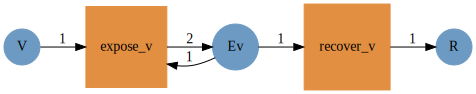

In [5]:
# An VEvR Model (Vaccinated, Exposed_Vaccinated, Recovered)
VEvR_opetri_net = Open(LabelledPetriNet(
    
    [:V, :Ev, :R], 

    :expose_v => ((:V, :Ev) => (:Ev, :Ev)),
    :recover_v => ((:Ev) => (:R)),
    )
)

to_graphviz(VEvR_opetri_net)

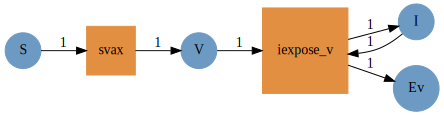

In [6]:
# Dicating cross exposure rules
cross_exposure_opetri_net = Open(LabelledPetriNet(
    
    [:S, :I, :V, :Ev], 

    :iexpose_v => ((:V, :I) => (:I, :Ev)),
    :svax => ((:S) => (:V)),
    )
)

to_graphviz(cross_exposure_opetri_net)

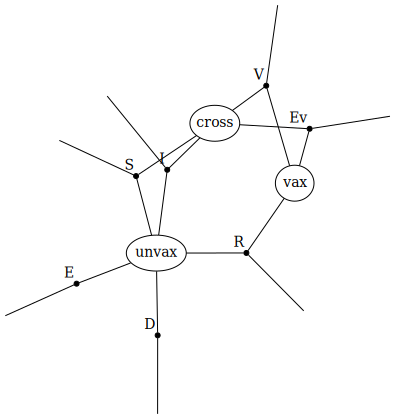

In [7]:
SVIEEvRD_composition_uwd = @relation (S, V, I, E, Ev, R, D) where (S, V, I, E, Ev, R, D) begin
    unvax(S, E, I, R, D)
    vax(V, Ev, R)
    cross(S, I, V, Ev)
end

to_graphviz(SVIEEvRD_composition_uwd, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len => "1"))

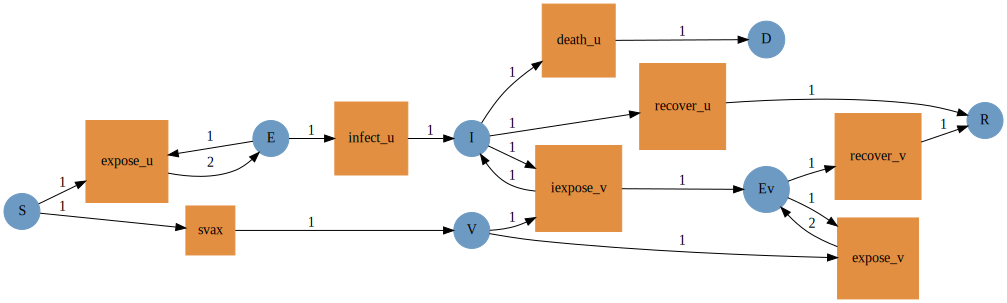

In [8]:
SVIEEvRD_opetri_net = oapply(
    SVIEEvRD_composition_uwd,
    Dict(:unvax => SEIRD_opetri_net, :vax => VEvR_opetri_net, :cross => cross_exposure_opetri_net) 
)

to_graphviz(SVIEEvRD_opetri_net)

Graph_typed (generic function with 2 methods)

In [10]:
# General population type
infectious_type = LabelledPetriNet(
    [:Pop],

    :interact => ((:Pop, :Pop) => (:Pop, :Pop)),
    :t_status => ((:Pop) => (:Pop))
)

s, = parts(infectious_type, :S) 
t_interact, t_status = parts(infectious_type, :T)
i_interact1, i_interact2, i_status = parts(infectious_type, :I) 
o_interact1, o_interact2, o_status = parts(infectious_type, :O)

infectious_type = map(infectious_type, Name=name->nothing)

AlgebraicPetri.LabelledPetriNetUntyped{Nothing} {T:2, S:1, I:3, O:3, Name:0}
┌───┬─────────┐
│ T │   tname │
├───┼─────────┤
│ 1 │ nothing │
│ 2 │ nothing │
└───┴─────────┘
┌───┬─────────┐
│ S │   sname │
├───┼─────────┤
│ 1 │ nothing │
└───┴─────────┘
┌───┬────┬────┐
│ I │ it │ is │
├───┼────┼────┤
│ 1 │  1 │  1 │
│ 2 │  1 │  1 │
│ 3 │  2 │  1 │
└───┴────┴────┘
┌───┬────┬────┐
│ O │ ot │ os │
├───┼────┼────┤
│ 1 │  1 │  1 │
│ 2 │  1 │  1 │
│ 3 │  2 │  1 │
└───┴────┴────┘

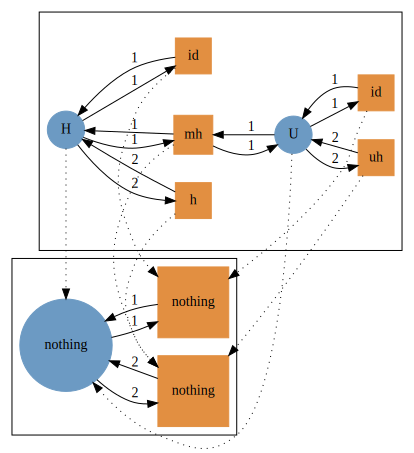

In [11]:
# Hygiene Stratification

hygiene_petri_net = LabelledPetriNet(
    [:H, :U],

    :h => ((:H, :H) => (:H, :H)),
    :uh => ((:U, :U) => (:U, :U)),
    :mh => ((:U, :H) => (:U, :H)),

    :id => (:H => :H),
    :id => (:U => :U),
)

typed_hygiene_petri_net = ACSetTransformation(
    hygiene_petri_net, infectious_type,    
    S = [s, s],  
        # expose,    infect,   recover,  die,      id begins
    T = [t_interact, t_interact, t_interact, t_status, t_status],  
    I = [i_interact1, i_interact2, i_interact1, i_interact2, i_interact1, i_interact2, i_status, i_status],  
    O = [o_interact1, o_interact2, o_interact1, o_interact2, o_interact1, o_interact2, o_status, o_status],
    Name = name -> nothing
)

to_graphviz(typed_hygiene_petri_net)


In [12]:
# Adding identity transitions to the compartments

function add_id(petrinet::LabelledPetriNet)
    n_comp = ns(petrinet)
    ts = add_transitions!(petrinet, n_comp, tname = :id) 
    add_inputs!(petrinet, n_comp, ts, 1:n_comp) 
    add_outputs!(petrinet, n_comp, ts, 1:n_comp)
    return petrinet    
end

SVIEEvRD_petri_net = add_id(apex(SVIEEvRD_opetri_net))

T,tname
1,expose_u
2,infect_u
3,recover_u
4,death_u
5,expose_v
6,recover_v
7,iexpose_v
8,svax
9,id
10,id


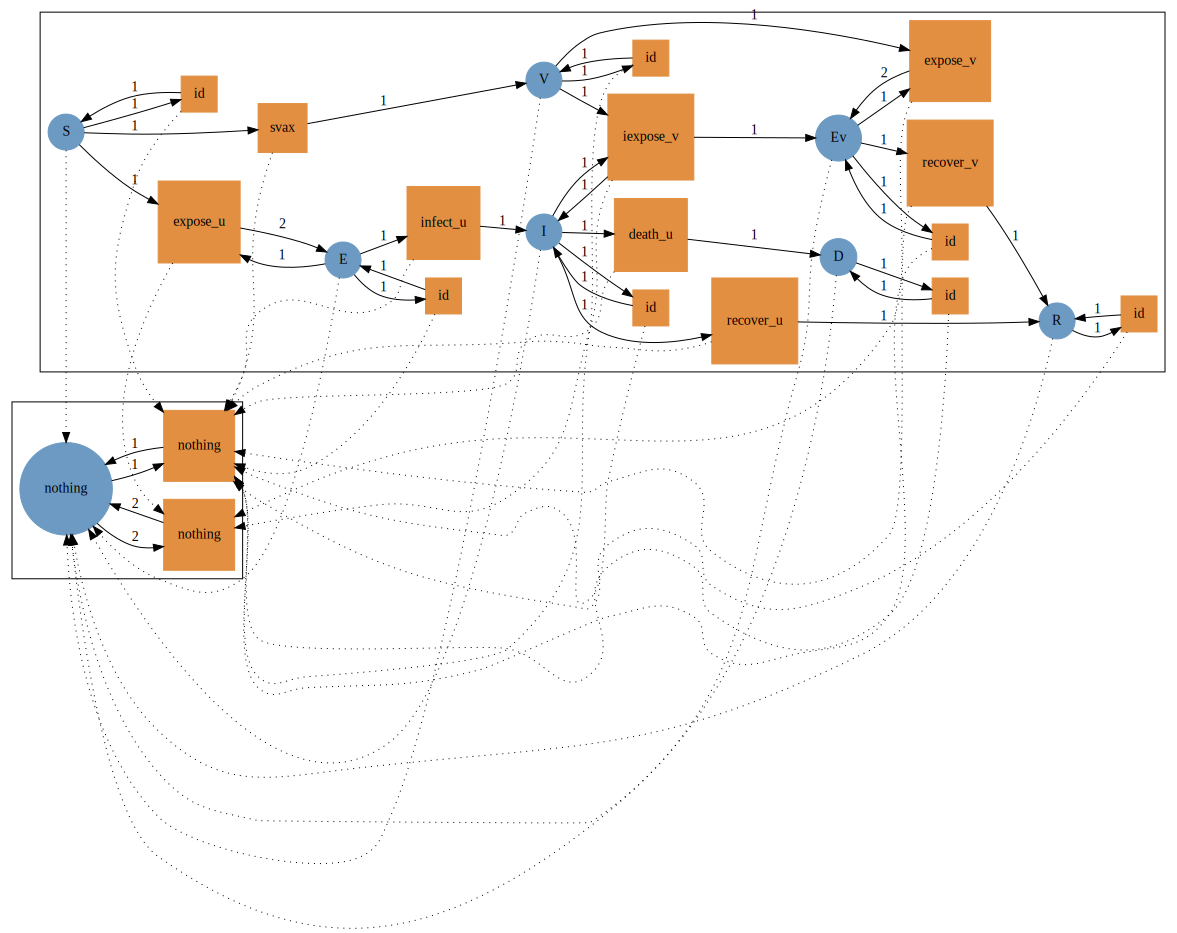

In [13]:
# Adding typing to the SVIEEvRD_petri_net

typed_SVIEEvRD_petri_net = ACSetTransformation(SVIEEvRD_petri_net, infectious_type,
    S = repeat([s], ns(SVIEEvRD_petri_net)),
    T = vcat(t_interact, t_status, t_status, t_status, t_interact, t_status, t_interact, t_status, repeat([t_status], ns(SVIEEvRD_petri_net))),
    I = vcat(i_interact1, i_interact2, i_status, i_status, i_status, i_interact1, i_interact2, i_status, i_interact1, i_interact2, i_status, repeat([i_status], ns(SVIEEvRD_petri_net))),
    O = vcat(o_interact1, o_interact2, o_status, o_status, o_status, o_interact1, o_interact2, o_status, o_interact1, o_interact2, o_status, repeat([o_status], ns(SVIEEvRD_petri_net))),
    Name = name -> nothing
)

@assert is_natural(typed_SVIEEvRD_petri_net)

to_graphviz(typed_SVIEEvRD_petri_net)

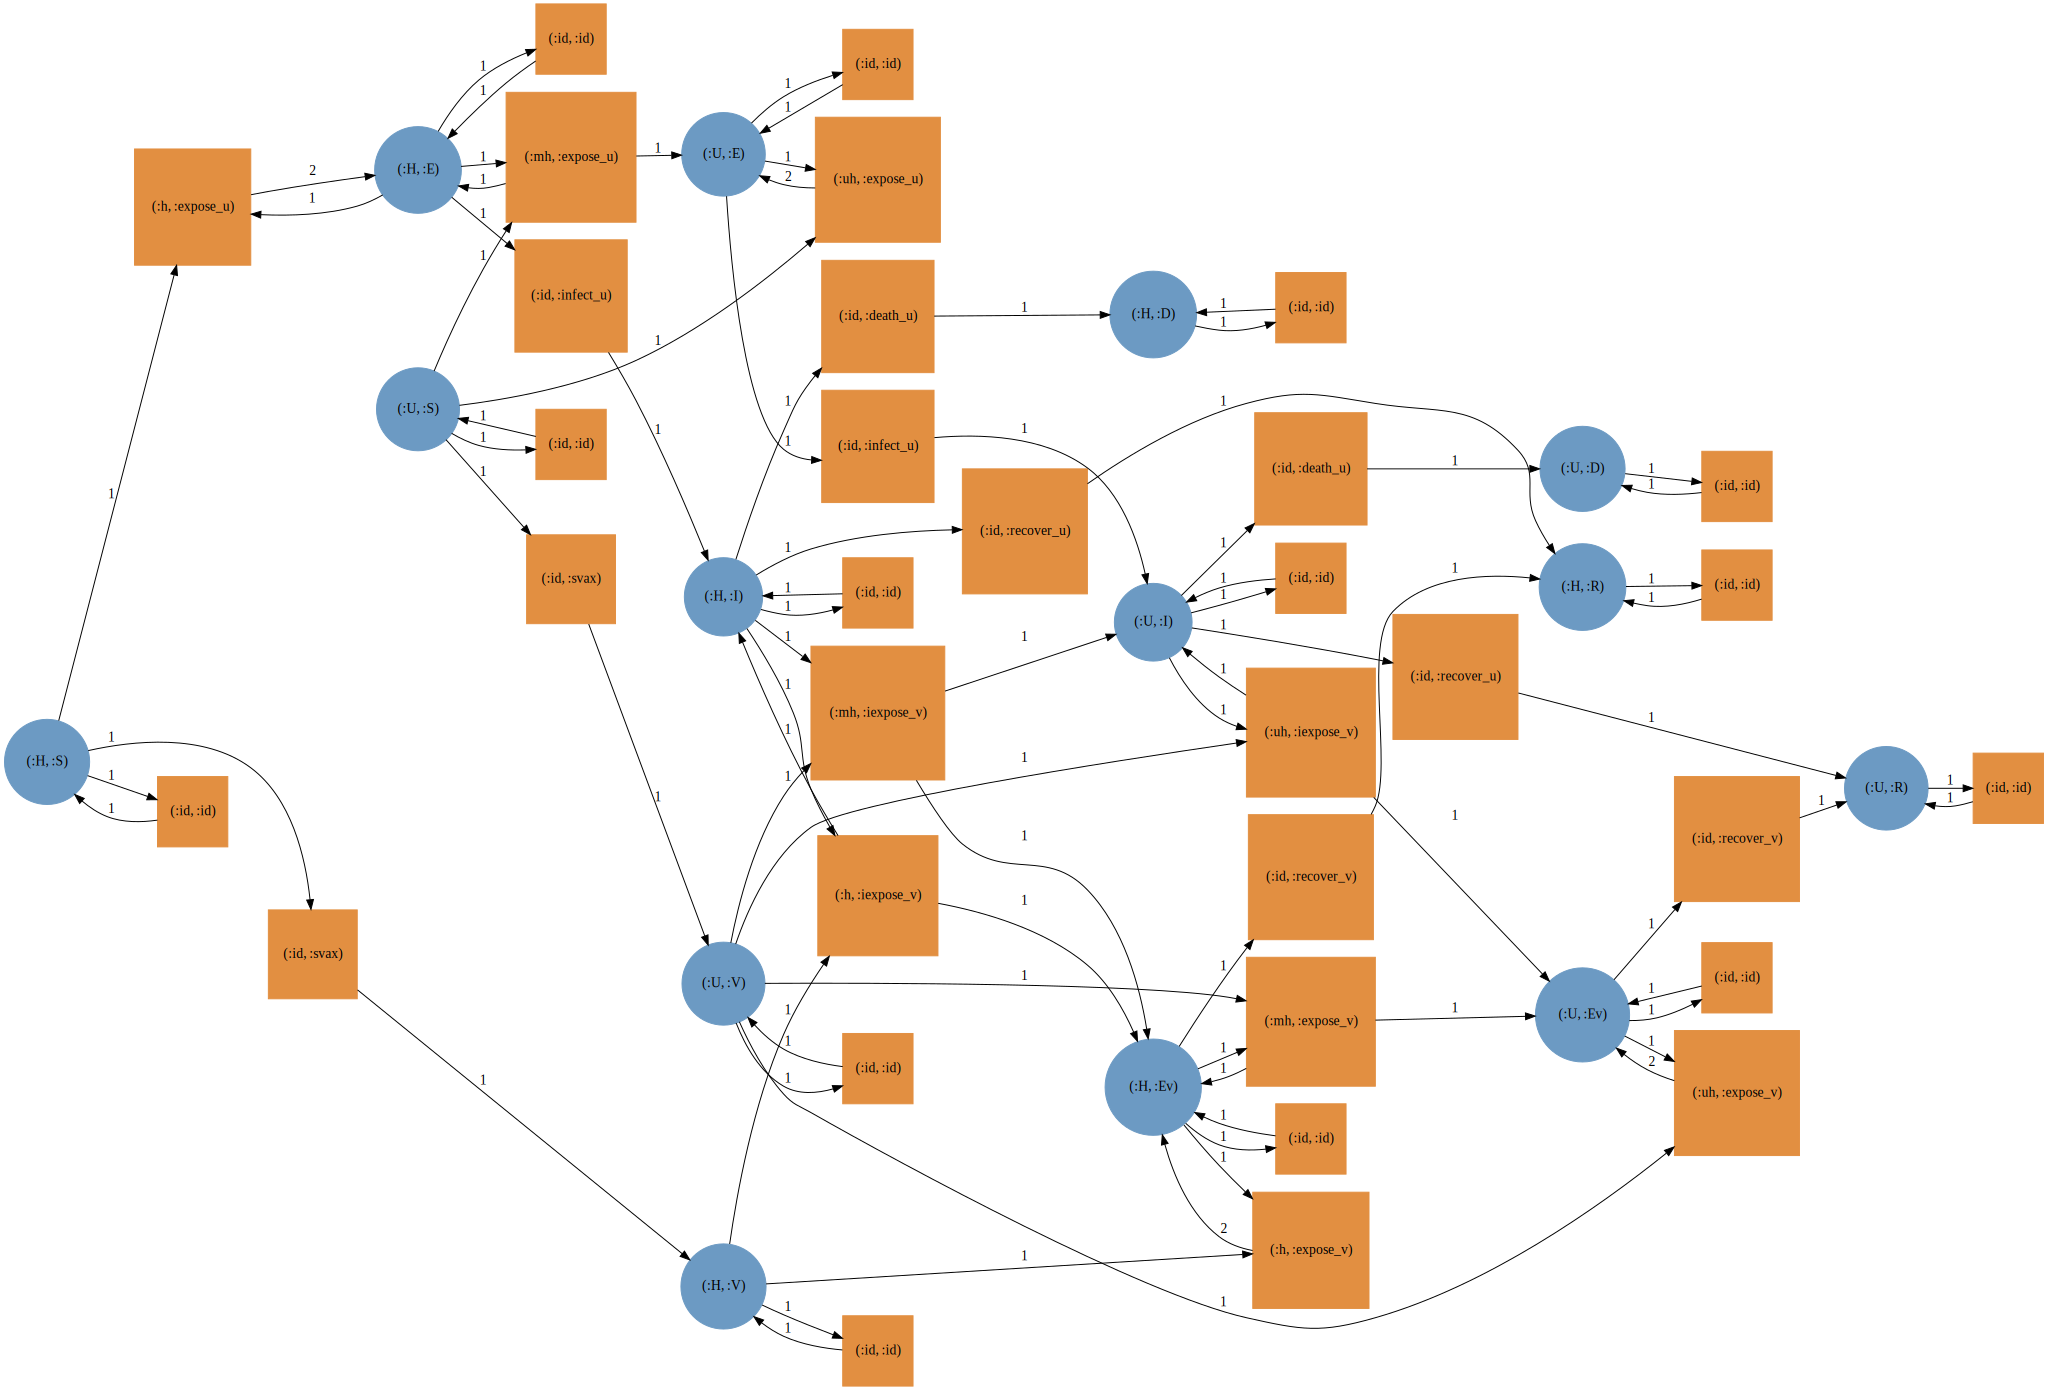

In [14]:
# Stratify the model
UH_SVIEEvRD_petri_net =  ob(pullback(typed_hygiene_petri_net, typed_SVIEEvRD_petri_net))
to_graphviz(UH_SVIEEvRD_petri_net)

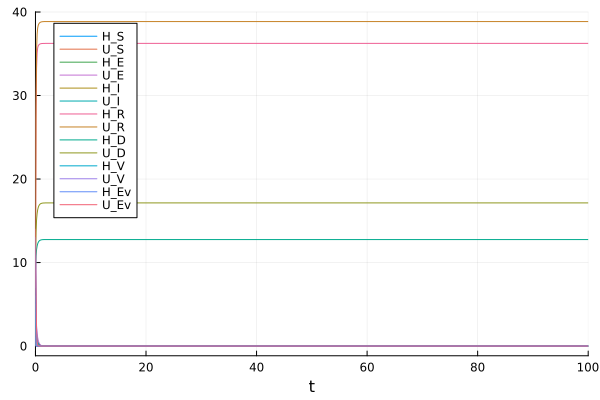

In [15]:
stratified_model = flatten_labels(UH_SVIEEvRD_petri_net)

p = @LArray [float(i) for i in 1:nt(stratified_model)] Tuple(x for x in tnames(stratified_model))
u0 = @LArray [float(i) for i in 1:ns(stratified_model)] Tuple(x for x in snames(stratified_model))

soln = solve(ODEProblem(vectorfield(stratified_model), u0, (0.0, 100.0), p))

plot(soln)


In [16]:
function flatten_stratified(petri_net)
    S, T = [], []

    for i = 1 : nt(petri_net)
        n = tname(petri_net, i)
        name = ""
        for j = 1 : length(n)
            name *= string(n[j]) 
            if j != length(n) name *=  "_" end
        end 

        append!(T, [Symbol(name)])
    end

    for i = 1 : ns(petri_net)
        n = sname(petri_net, i)
        name = ""
        for j = 1 : length(n)
            name *= string(n[j]) 
            if j != length(n) name *=  "_" end
        end 

        append!(S, [Symbol(name)])
    end

    I = parts(petri_net, :I)
    O = parts(petri_net, :O)

    for i in I
        print(i)
    end
    
    flat = LabelledPetriNet(S)

    print(nt(petri_net))
    print(length(T))

    ts = add_transitions!(flat, nt(petri_net), tname = T)

    print(flat)
    add_inputs!(flat, ni(petri_net), ts, s, I) 
    add_outputs!(flat, no(petri_net), ts, s, O)

    return flat
end

flatten_stratified (generic function with 1 method)

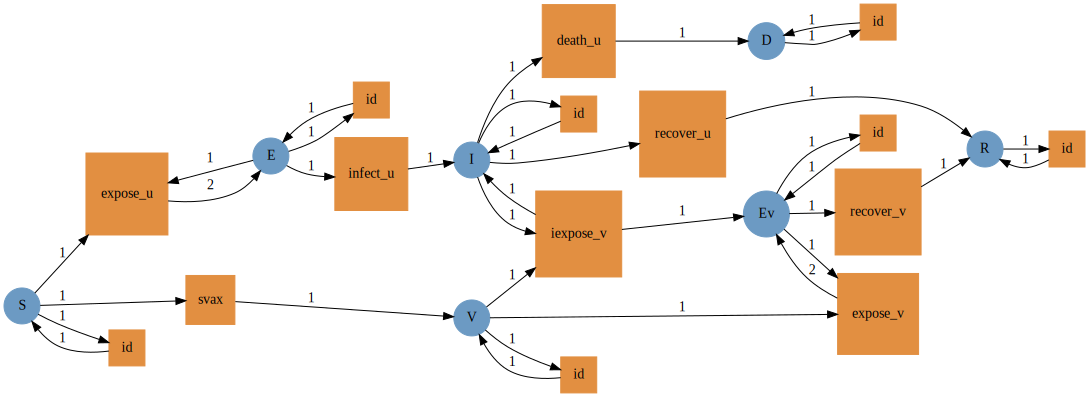

In [32]:
Graph_typed(typed_SVIEEvRD_petri_net)